## 序列到序列学习（seq2seq）
正如我们在 9.5节中看到的，机器翻译中的输⼊序列和输出序列都是⻓度可变的。为了解决这类问题，我们
在 9.6节中设计了⼀个通⽤的”编码器－解码器“架构。本节，我们将使⽤两个循环神经⽹络的编码器和解码
器，并将其应⽤于序列到序列（sequence to sequence，seq2seq）类的学习任务 (Cho et al., 2014, Sutskever
et al., 2014)。

遵循编码器－解码器架构的设计原则，循环神经⽹络编码器使⽤⻓度可变的序列作为输⼊，将其转换为固定
形状的隐状态。换⾔之，输⼊序列的信息被编码到循环神经⽹络编码器的隐状态中。为了连续⽣成输出序列
的词元，独⽴的循环神经⽹络解码器是基于输⼊序列的编码信息和输出序列已经看⻅的或者⽣成的词元来预
测下⼀个词元。图9.7.1演⽰了如何在机器翻译中使⽤两个循环神经⽹络进⾏序列到序列学习。

遵循编码器－解码器架构的设计原则，循环神经⽹络编码器使⽤⻓度可变的序列作为输⼊，将其转换为固定
形状的隐状态。换⾔之，输⼊序列的信息被编码到循环神经⽹络编码器的隐状态中。为了连续⽣成输出序列
的词元，独⽴的循环神经⽹络解码器是基于输⼊序列的编码信息和输出序列已经看⻅的或者⽣成的词元来预
测下⼀个词元。图9.7.1演⽰了如何在机器翻译中使⽤两个循环神经⽹络进⾏序列到序列学习。

在 图9.7.1中，特定的“<eos>”表⽰序列结束词元。⼀旦输出序列⽣成此词元，模型就会停⽌预测。在循环神
经⽹络解码器的初始化时间步，有两个特定的设计决定：⾸先，特定的“<bos>”表⽰序列开始词元，它是解
码器的输⼊序列的第⼀个词元。其次，使⽤循环神经⽹络编码器最终的隐状态来初始化解码器的隐状态。例
如，在 (Sutskever et al., 2014)的设计中，正是基于这种设计将输⼊序列的编码信息送⼊到解码器中来⽣成输
出序列的。在其他⼀些设计中 (Cho et al., 2014)，如 图9.7.1所⽰，编码器最终的隐状态在每⼀个时间步都作
为解码器的输⼊序列的⼀部分。类似于 8.3节中语⾔模型的训练，可以允许标签成为原始的输出序列，从源
序列词元“<bos>”“Ils”“regardent”“.”到新序列词元“Ils”“regardent”“.”“<eos>”来移动预测的位置。
下⾯，我们动⼿构建 图9.7.1的设计，并将基于 9.5节中介绍的“英－法”数据集来训练这个机器翻译模型。

In [1]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l


## 编码器
从技术上讲，编码器将⻓度可变的输⼊序列转换成形状固定的上下⽂变量c，并且将输⼊序列的信息在该上
下⽂变量中进⾏编码。如 图9.7.1所⽰，可以使⽤循环神经⽹络来设计编码器。
考虑由⼀个序列组成的样本（批量⼤⼩是1）。假设输⼊序列是x1, . . . , xT，其中xt是输⼊⽂本序列中的第t个
词元。在时间步t，循环神经⽹络将词元xt的输⼊特征向量 xt和ht−1（即上⼀时间步的隐状态）转换为ht（即
当前步的隐状态）。使⽤⼀个函数f来描述循环神经⽹络的循环层所做的变换：  
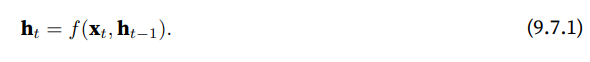  

总之，编码器通过选定的函数q，将所有时间步的隐状态转换为上下⽂变量：  

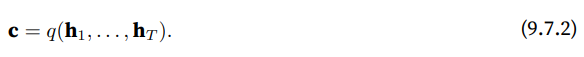  

⽐如，当选择q(h1, . . . , hT ) = hT时（就像 图9.7.1中⼀样），上下⽂变量仅仅是输⼊序列在最后时间步的隐状
态hT。

到⽬前为⽌，我们使⽤的是⼀个单向循环神经⽹络来设计编码器，其中隐状态只依赖于输⼊⼦序列，这个⼦
序列是由输⼊序列的开始位置到隐状态所在的时间步的位置（包括隐状态所在的时间步）组成。我们也可以
使⽤双向循环神经⽹络构造编码器，其中隐状态依赖于两个输⼊⼦序列，两个⼦序列是由隐状态所在的时间
步的位置之前的序列和之后的序列（包括隐状态所在的时间步），因此隐状态对整个序列的信息都进⾏了编
码。  
现在，让我们实现循环神经⽹络编码器。注意，我们使⽤了嵌⼊层（embedding layer）来获得输⼊序列中每
个词元的特征向量。嵌⼊层的权重是⼀个矩阵，其⾏数等于输⼊词表的⼤⼩（vocab_size），其列数等于特征
向量的维度（embed_size）。对于任意输⼊词元的索引i，嵌⼊层获取权重矩阵的第i⾏（从0开始）以返回其
特征向量。另外，本⽂选择了⼀个多层⻔控循环单元来实现编码器。


In [2]:
#@save
class Seq2SeqEncoder(d2l.Encoder):
    """⽤于序列到序列学习的循环神经⽹络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌⼊层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        # 在循环神经⽹络模型中，第⼀个轴对应于时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

循环层返回变量的说明可以参考 8.6节。
下⾯，我们实例化上述编码器的实现：我们使⽤⼀个两层⻔控循环单元编码器，其隐藏单元数为16。给定⼀
⼩批量的输⼊序列X（批量⼤⼩为4，时间步为7）。在完成所有时间步后，最后⼀层的隐状态的输出是⼀个张
量（output由编码器的循环层返回），其形状为（时间步数，批量⼤⼩，隐藏单元数）。


In [3]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

由于这⾥使⽤的是⻔控循环单元，所以在最后⼀个时间步的多层隐状态的形状是（隐藏层的数量，批量⼤⼩，
隐藏单元的数量）。如果使⽤⻓短期记忆⽹络，state中还将包含记忆单元信息。

In [4]:
state.shape

torch.Size([2, 4, 16])

## 解码器
正如上⽂提到的，编码器输出的上下⽂变量c 对整个输⼊序列x1, . . . , xT进⾏编码。来⾃训练数据集的输出序
列y1, y2, . . . , yT′，对于每个时间步t′（与输⼊序列或编码器的时间步t不同），解码器输出yt′的概率取决于先
前的输出⼦序列 y1, . . . , yt′−1和上下⽂变量c，即P(yt′ | y1, . . . , yt′−1, c)。  
为了在序列上模型化这种条件概率，我们可以使⽤另⼀个循环神经⽹络作为解码器。在输出序列上的任意时
间步t′，循环神经⽹络将来⾃上⼀时间步的输出yt′−1 和上下⽂变量c作为其输⼊，然后在当前时间步将它们
和上⼀隐状态 st′−1转换为隐状态st′。因此，可以使⽤函数g来表⽰解码器的隐藏层的变换：

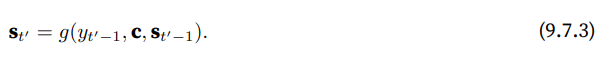  

在获得解码器的隐状态之后，我们可以使⽤输出层和softmax操作来计算在时间步t
′时输出yt′的条件概率分布 P(yt′ | y1, . . . , yt′−1, c)。  

根据 图9.7.1，当实现解码器时，我们直接使⽤编码器最后⼀个时间步的隐状态来初始化解码器的隐状态。这
就要求使⽤循环神经⽹络实现的编码器和解码器具有相同数量的层和隐藏单元。为了进⼀步包含经过编码的
输⼊序列的信息，上下⽂变量在所有的时间步与解码器的输⼊进⾏拼接（concatenate）。为了预测输出词元
的概率分布，在循环神经⽹络解码器的最后⼀层使⽤全连接层来变换隐状态。


In [5]:
class Seq2SeqDecoder(d2l.Decoder):
    """⽤于序列到序列学习的循环神经⽹络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
    
    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # ⼴播context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state


下⾯，我们⽤与前⾯提到的编码器中相同的超参数来实例化解码器。如我们所⻅，解码器的输出形状变为（批
量⼤⼩，时间步数，词表⼤⼩），其中张量的最后⼀个维度存储预测的词元分布。

In [6]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

上述循环神经⽹络“编码器－解码器”模型中的各层如 图9.7.2所⽰。  
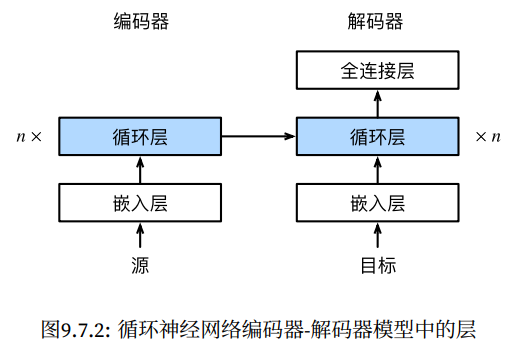

## 损失函数
在每个时间步，解码器预测了输出词元的概率分布。类似于语⾔模型，可以使⽤softmax来获得分布，并通过
计算交叉熵损失函数来进⾏优化。回想⼀下 9.5节中，特定的填充词元被添加到序列的末尾，因此不同⻓度
的序列可以以相同形状的⼩批量加载。但是，我们应该将填充词元的预测排除在损失函数的计算之外。

为此，我们可以使⽤下⾯的sequence_mask函数通过零值化屏蔽不相关的项，以便后⾯任何不相关预测的计
算都是与零的乘积，结果都等于零。例如，如果两个序列的有效⻓度（不包括填充词元）分别为1和2，则第
⼀个序列的第⼀项和第⼆个序列的前两项之后的剩余项将被清除为零。

In [7]:
#@save
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))


tensor([[1, 0, 0],
        [4, 5, 0]])

还可以使⽤此函数屏蔽最后⼏个轴上的所有项。如果愿意，也可以使⽤指定的⾮零值来替换这些项。


In [8]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

现在，我们可以通过扩展softmax交叉熵损失函数来遮蔽不相关的预测。最初，所有预测词元的掩码都设置
为1。⼀旦给定了有效⻓度，与填充词元对应的掩码将被设置为0。最后，将所有词元的损失乘以掩码，以过
滤掉损失中填充词元产⽣的不相关预测。


In [9]:
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

我们可以创建三个相同的序列来进⾏代码健全性检查，然后分别指定这些序列的有效⻓度为4、2和0。结果就
是，第⼀个序列的损失应为第⼆个序列的两倍，⽽第三个序列的损失应为零。

In [10]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))


tensor([2.3026, 1.1513, 0.0000])

## 训练
在下⾯的循环训练过程中，如 图9.7.1所⽰，特定的序列开始词元（“<bos>”）和原始的输出序列（不包括序
列结束词元“<eos>”）拼接在⼀起作为解码器的输⼊。这被称为强制教学（teacher forcing），因为原始的输
出序列（词元的标签）被送⼊解码器。或者，将来⾃上⼀个时间步的预测得到的词元作为解码器的当前输⼊。

In [11]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2) # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1) # 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward() # 损失函数的标量进⾏“反向传播”
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')


现在，在机器翻译数据集上，我们可以创建和训练⼀个循环神经⽹络“编码器－解码器”模型⽤于序列到序
列的学习。


loss 0.019, 17067.3 tokens/sec on cuda:0


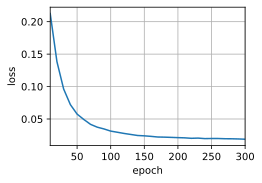

In [12]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## 预测
为了采⽤⼀个接着⼀个词元的⽅式预测输出序列，每个解码器当前时间步的输⼊都将来⾃于前⼀时间步的预
测词元。与训练类似，序列开始词元（“<bos>”）在初始时间步被输⼊到解码器中。该预测过程如 图9.7.3所
⽰，当输出序列的预测遇到序列结束词元（“<eos>”）时，预测就结束了。  
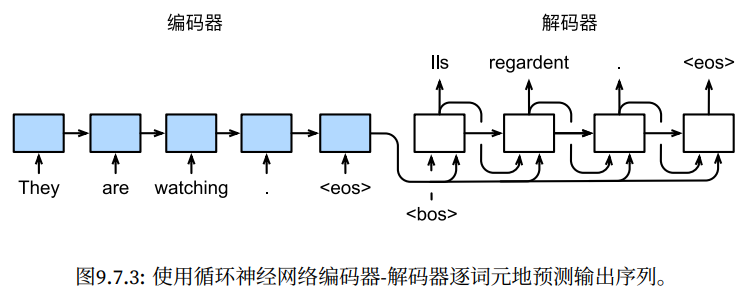  

介绍不同的序列⽣成策略。

In [13]:
#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使⽤具有预测最⾼可能性的词元，作为解码器在下⼀时间步的输⼊
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意⼒权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # ⼀旦序列结束词元被预测，输出序列的⽣成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq


## 预测序列的评估
我们可以通过与真实的标签序列进⾏⽐较来评估预测序列。虽然(Papineni et al., 2002)提出的BLEU（bilingual
evaluation understudy）最先是⽤于评估机器翻译的结果，但现在它已经被⼴泛⽤于测量许多应⽤的输出序
列的质量。原则上说，对于预测序列中的任意n元语法（n-grams），BLEU的评估都是这个n元语法是否出现
在标签序列中。  

我们将BLEU定义为：
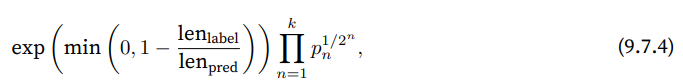  

其中lenlabel表⽰标签序列中的词元数和 lenpred表⽰预测序列中的词元数，k是⽤于匹配的最⻓的n元语法。另
外，⽤pn表⽰n元语法的精确度，它是两个数量的⽐值：第⼀个是预测序列与标签序列中匹配的n元语法的数
量，第⼆个是预测序列中n元语法的数量的⽐率。具体地说，给定标签序列A、B、C、D、E、F 和预测序
列A、B、B、C、D，我们有p1 = 4/5、p2 = 3/4、p3 = 1/3和p4 = 0。

根据 (9.7.4)中BLEU的定义，当预测序列与标签序列完全相同时，BLEU为1。此外，由于n元语法越⻓则匹配
难度越⼤，所以BLEU为更⻓的n元语法的精确度分配更⼤的权重。具体来说，当pn固定时，p1/2n
n 会随着n的增⻓⽽增加（原始论⽂使⽤p1/n_n ）。⽽且，由于预测的序列越短获得的pn值越⾼，所以 (9.7.4)中乘法项之前的
系数⽤于惩罚较短的预测序列。例如，当k = 2时，给定标签序列A、B、C、D、E、F 和预测序列A、B，尽
管p1 = p2 = 1，惩罚因⼦exp(1 − 6/2) ≈ 0.14会降低BLEU。

BLEU的代码实现如下。


In [14]:
def bleu(pred_seq, label_seq, k): #@save
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

最后，利⽤训练好的循环神经⽹络“编码器－解码器”模型，将⼏个英语句⼦翻译成法语，并计算BLEU的最
终结果。


In [15]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')


go . => va !, bleu 1.000
i lost . => j'ai perdu le est la est <unk> ., bleu 0.376
he's calm . => il est malade ., bleu 0.658
i'm home . => je suis chez moi ., bleu 1.000


## 小结
* 根据“编码器-解码器”架构的设计，我们可以使⽤两个循环神经⽹络来设计⼀个序列到序列学习的模型。
* 在实现编码器和解码器时，我们可以使⽤多层循环神经⽹络。
* 我们可以使⽤遮蔽来过滤不相关的计算，例如在计算损失时。
* 在“编码器－解码器”训练中，强制教学⽅法将原始输出序列（⽽⾮预测结果）输⼊解码器。
* BLEU是⼀种常⽤的评估⽅法，它通过测量预测序列和标签序列之间的n元语法的匹配度来评估预测。
